## RA

Utilities to handle "problems":

- https://github.com/JuliaDiffEq/DiffEqBase.jl/blob/87667e11c6c372ce1a1ec1c50600bad5e42691f8/src/problems/problem_utils.jl

In [35]:
using Revise, ReachabilityAnalysis
const RA = ReachabilityAnalysis

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1273


ReachabilityAnalysis

In [3]:
p = @ivp(x' = -x, x(0) ∈ 0..1)

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %   Cloning git-repo `https://github.com/mforets/ReachabilityAnalysis.jl.git`
  Updating git-repo `https://github.com/mforets/ReachabilityAnalysis.jl.git`g: [==============================>          ]  74.8 %Fetching: [=====================================>   ]  91.2 %
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...


┌ Info: Path `/home/mforets/.julia/dev/ReachabilityAnalysis` exists and looks like the correct package, using existing path
└ @ Pkg.Types /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.3/Pkg/src/Types.jl:560


  Updating `~/.julia/environments/v1.3/Project.toml`
  [1e97bd63] + ReachabilityAnalysis v0.1.0 [`~/.julia/dev/ReachabilityAnalysis`]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [1e97bd63] + ReachabilityAnalysis v0.1.0 [`~/.julia/dev/ReachabilityAnalysis`]


In [ ]:
@ivp(x' = -1.01x)

In [ ]:
solve(p, T=1.0)

In [13]:
using DifferentialEquations
f(u,p,t) = 1.01*u
u0 = 1/2
tspan = (0.0,1.0)
prob = ODEProblem(f,u0,tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 0.5

In [24]:
solve(prob);

In [25]:
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

In [27]:
sol = solve(prob,Euler(),dt=1/2^4);

In [28]:
sol = solve(prob,dt=1/2^4, Euler());

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


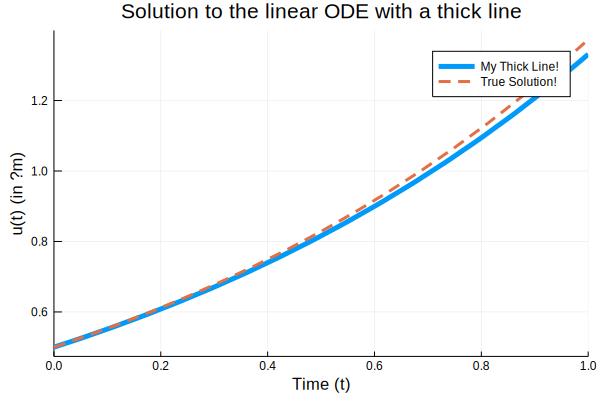

In [29]:
using Plots
plot(sol,linewidth=5,title="Solution to the linear ODE with a thick line",
     xaxis="Time (t)",yaxis="u(t) (in μm)",label="My Thick Line!") # legend=false
plot!(sol.t, t->0.5*exp(1.01t),lw=3,ls=:dash,label="True Solution!")

## Kronecker products

In [30]:
using Kronecker, BenchmarkTools, Test, DynamicPolynomials
using BenchmarkTools
using StaticArrays

# using BernsteinExpansions

In [31]:
A = rand(3)
B = rand(4);

In [32]:
h = hcat(A) ⊗ hcat(B);

In [33]:
kron(hcat(A), hcat(B))

12×1 Array{Float64,2}:
 0.517253235988539   
 0.436560576290533   
 0.5805462522852999  
 0.0828575758785168  
 0.15660486691940845 
 0.1321741580245117  
 0.17576761681528696 
 0.025086164263276693
 0.45168032841642053 
 0.3812171887058797  
 0.5069496015660626  
 0.07235360647492635 

In [34]:
@btime kron($A, $B);

  138.199 ns (7 allocations: 448 bytes)


- Ideas from https://discourse.julialang.org/t/outer-broadcasting/22701/5

- The function used is `*`, see [mul_float](https://github.com/JuliaLang/julia/blob/2d5741174ce3e6a394010d2e470e4269ca54607f/base/float.jl#L405)

In [35]:
outer(arrays...) = [Base.mul_float(x...) for x in Iterators.product(arrays...)]

outer (generic function with 1 method)

In [36]:
outer(A, B)

3×4 Array{Float64,2}:
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [37]:
@btime outer($A, $B)

  47.999 ns (4 allocations: 240 bytes)


3×4 Array{Float64,2}:
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [38]:
As = SVector{3, Float64}(A)
Bs = SVector{4, Float64}(B)

4-element SArray{Tuple{4},Float64,1,4} with indices SOneTo(4):
 0.7292229650717279 
 0.6154625543668104 
 0.8184533802745433 
 0.11681250682813804

In [39]:
outer(As, Bs)

3×4 SizedArray{Tuple{3,4},Float64,2,2} with indices SOneTo(3)×SOneTo(4):
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [40]:
@btime outer($As, $Bs)

  65.669 ns (4 allocations: 304 bytes)


3×4 SizedArray{Tuple{3,4},Float64,2,2} with indices SOneTo(3)×SOneTo(4):
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [41]:
function outer_s(V1, V2)
    n1 = length(V1)
    n2 = length(V2)
    M = MArray{Tuple{n1, n2}, Float64, 2}(undef)
    for i in 1:n2
        @inbounds M[:, i] = V1 * V2[i]
    end
    return M
end

outer_s (generic function with 1 method)

In [42]:
outer_s(As, Bs)

3×4 MArray{Tuple{3,4},Float64,2,12} with indices SOneTo(3)×SOneTo(4):
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [43]:
outer(A, B)

3×4 Array{Float64,2}:
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [44]:
@btime outer_s($As, $Bs)

  10.865 ns (1 allocation: 112 bytes)


3×4 MArray{Tuple{3,4},Float64,2,12} with indices SOneTo(3)×SOneTo(4):
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [45]:
@btime outer($A, $B)

  47.892 ns (4 allocations: 240 bytes)


3×4 Array{Float64,2}:
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [46]:
y = Iterators.product(arrays...)

UndefVarError: UndefVarError: arrays not defined

In [47]:
m = MArray{Tuple{3, 4}, Float64, 2}(undef)

3×4 MArray{Tuple{3,4},Float64,2,12} with indices SOneTo(3)×SOneTo(4):
 6.94502e-310  1.4822e-323  0.580546      6.94505e-310
 1.4822e-323   1.4822e-323  0.175768      6.94505e-310
 2.81295e-318  0.381217     6.94505e-310  0.0723536   

In [48]:
m

3×4 MArray{Tuple{3,4},Float64,2,12} with indices SOneTo(3)×SOneTo(4):
 6.94502e-310  1.4822e-323  0.580546      6.94505e-310
 1.4822e-323   1.4822e-323  0.175768      6.94505e-310
 2.81295e-318  0.381217     6.94505e-310  0.0723536   

In [49]:
for (i, x) in enumerate(Iterators.product((A, B)...))
    println(i)
end

1
2
3
4
5
6
7
8
9
10
11
12


In [50]:
@generated function outer_g(f, args::Tuple{Vararg{Any, N}}) where {N}
    expr = Expr(:call, :broadcast, :f)
    for i in 1:N
        if i == 1
            push!(expr.args, :(args[1]))
        else
            push!(expr.args, Expr(:call, :reshape, :(args[$i]), Expr(:tuple, [1 for _ in 1:i - 1]..., :(:))))
        end
    end
    expr
end

@generated function outer_mul(args::Tuple{Vararg{Any, N}}) where {N}
    expr = Expr(:call, :broadcast, :(Base.mul_float)
    for i in 1:N
        if i == 1
            push!(expr.args, :(args[1]))
        else
            push!(expr.args, Expr(:call, :reshape, :(args[$i]), Expr(:tuple, [1 for _ in 1:i - 1]..., :(:))))
        end
    end
    expr
end

LoadError: syntax: missing comma or ) in argument list

In [51]:
@btime outer_g(Base.mul_float, ($A, $B));

  2.323 μs (79 allocations: 1.92 KiB)


In [52]:
const arrays2 = (A, B)
@btime outer_mul($arrays2)

UndefVarError: UndefVarError: outer_mul not defined

In [53]:
@btime outer($A, $B)

  47.922 ns (4 allocations: 240 bytes)


3×4 Array{Float64,2}:
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

## Three vectors

In [54]:
A

3-element Array{Float64,1}:
 0.7093211003546231 
 0.21475580778507775
 0.6193994841783299 

In [55]:
B

4-element Array{Float64,1}:
 0.7292229650717279 
 0.6154625543668104 
 0.8184533802745433 
 0.11681250682813804

In [56]:
C = rand(2)

2-element Array{Float64,1}:
 0.12482653855927328
 0.8132835764375597 

In [57]:
As = SVector{3, Float64}(A)
Bs = SVector{4, Float64}(B)
Cs = SVector{2, Float64}(C);

In [58]:
M = outer_s(As, Bs)

3×4 MArray{Tuple{3,4},Float64,2,12} with indices SOneTo(3)×SOneTo(4):
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [59]:
M * Cs[1]

3×4 MArray{Tuple{3,4},Float64,2,12} with indices SOneTo(3)×SOneTo(4):
 0.0645669  0.0544943  0.0724676  0.0103428 
 0.0195484  0.0164988  0.0219405  0.00313142
 0.0563817  0.047586   0.0632808  0.00903165

In [60]:
function outer_s(V1, V2, V3)
    n1 = length(V1)
    n2 = length(V2)
    M = MArray{Tuple{n1, n2}, Float64}(undef)
    for i in 1:n2
        @inbounds M[:, i] = V1 .* V2[i]
    end
    
    n3 = length(V3)
    Q = MArray{Tuple{n1, n2, n3}, Float64}(undef)
    for i in 1:n3
        @inbounds Q[:, :, i] = M .* V3[i]
    end
    return Q
end

outer_s (generic function with 2 methods)

In [61]:
@btime outer_s($As, $Bs, $Cs);

  16.886 ns (1 allocation: 208 bytes)


In [62]:
As

3-element SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
 0.7093211003546231 
 0.21475580778507775
 0.6193994841783299 

In [63]:
Am = SMatrix{3, 1, Float64}(A)
Bm = SMatrix{4, 1, Float64}(B)
Cm = SMatrix{2, 1, Float64}(C)

2×1 SArray{Tuple{2,1},Float64,2,2} with indices SOneTo(2)×SOneTo(1):
 0.12482653855927328
 0.8132835764375597 

In [64]:
function outer_s_v2(A, B)
    return A * B'
end

outer_s_v2 (generic function with 1 method)

In [65]:
outer_s(As, Bs)

3×4 MArray{Tuple{3,4},Float64,2,12} with indices SOneTo(3)×SOneTo(4):
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [66]:
outer_s_v2(As, Bs)

3×4 SArray{Tuple{3,4},Float64,2,12} with indices SOneTo(3)×SOneTo(4):
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [67]:
@btime outer_s_v2($As, $Bs)

  0.016 ns (0 allocations: 0 bytes)


3×4 SArray{Tuple{3,4},Float64,2,12} with indices SOneTo(3)×SOneTo(4):
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [68]:
outer_s_v2(As, Bs)

3×4 SArray{Tuple{3,4},Float64,2,12} with indices SOneTo(3)×SOneTo(4):
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

In [69]:
h = hcat(A) ⊗ hcat(B) ⊗ hcat(C);

In [70]:
@btime collect($h);

  92.654 ns (2 allocations: 448 bytes)


## Assemble: vector vs multidim array

Given a vector `v` and a multi-dimensional array `M`, the function `assemble`

In [71]:
?SVector

search: SVector @SVector DenseVector SizedVector StaticVector AbstractVector



```
SVector{S, T}(x::NTuple{S, T})
SVector{S, T}(x1, x2, x3, ...)
```

Construct a statically-sized vector `SVector`. Since this type is immutable, the data must be provided upon construction and cannot be mutated later. Constructors may drop the `T` and `S` parameters if they are inferrable from the input (e.g. `SVector(1,2,3)` constructs an `SVector{3, Int}`).

```
SVector{S}(vec::Vector)
```

Construct a statically-sized vector of length `S` using the data from `vec`. The parameter `S` is mandatory since the length of `vec` is unknown to the compiler (the element type may optionally also be specified).


In [72]:
function assemble(vec::SVector{L, T}, src::MArray{S, T}) where {L, T}
    dst = MArray{Tupl(undef)
end

function assemble!(dst, vec, src)
    
end

LoadError: syntax: missing comma or } in argument list

In [73]:
using LinearAlgebra

In [74]:
s = Tuple{3, 4, 5}
(s..., 5)

MethodError: MethodError: no method matching iterate(::Type{Tuple{3,4,5}})
Closest candidates are:
  iterate(!Matched::Core.SimpleVector) at essentials.jl:600
  iterate(!Matched::Core.SimpleVector, !Matched::Any) at essentials.jl:600
  iterate(!Matched::ExponentialBackOff) at error.jl:218
  ...

In [75]:
x = @MVector(rand(2))

2-element MArray{Tuple{2},Float64,1,2} with indices SOneTo(2):
 0.04823083105462511
 0.07866426427553241

In [76]:
y = @MMatrix(rand(2, 2))

2×2 MArray{Tuple{2,2},Float64,2,4} with indices SOneTo(2)×SOneTo(2):
 0.684286   0.409102
 0.0335525  0.351199

In [77]:
outer(x, y)

2×2×2 SizedArray{Tuple{2,2,2},Float64,3,3} with indices SOneTo(2)×SOneTo(2)×SOneTo(2):
[:, :, 1] =
 0.0330037  0.00161826
 0.0538288  0.00263938

[:, :, 2] =
 0.0197313  0.0169386
 0.0321817  0.0276268

## Generated product

In [78]:
using StaticArrays

using Base.Cartesian

In [79]:
@generated function _tensor_generated!(A::AbstractArray{T, N}, v) where {T, N}
    quote
        @inbounds for $(Symbol(:i_, N)) in eachindex(v[$N])
                  @nloops $(N-1) i i -> eachindex(v[i]) d -> d == 1 ?
                            nothing :
                            d == $N-1 ?
                                    t_{d-1} = v[i_{d}, d] * v[i_{d+1}, d+1] :
                                    t_{d-1} = t_{d} * v[i_{d}][d] begin
                                        if $N==2
                                            (@nref $N A i) = v[i_1, 1] * v[i_2, 2]
                                        else
                                            (@nref $N A i) = t_1 * v[i_1, 1]
                                        end
                                end
               end
     end
end

function outer_gen(array)
    ndims = length(array)
    lengths = Tuple(length(ai) for ai in array)
    dst = Array{Float64, ndims}(undef, lengths)
    _tensor_generated!(dst, array)
    return dst
end

outer_gen (generic function with 1 method)

In [94]:
A = rand(2)
B = rand(3)

3-element Array{Float64,1}:
 0.49045263575638476 
 0.9374432227378064  
 0.025626237532135665

In [81]:
using RecursiveArrayTools

In [95]:
array = VectorOfArray([A, B])

2-element Array{Array{Float64,1},1}:
 [0.046636187088634706, 0.3252387580700036]                     
 [0.49045263575638476, 0.9374432227378064, 0.025626237532135665]

In [83]:
ndims = length(array)

dst = Array{Float64, ndims}(undef, size(array))
#_tensor_generated!(dst, array)

2×2 Array{Float64,2}:
 6.94502e-310  6.94502e-310
 6.94502e-310  6.94508e-310

In [99]:
@btime outer_gen($array)

  445.985 ns (4 allocations: 272 bytes)


2×3 Array{Float64,2}:
 0.0228728  0.0437188  0.00119511
 0.159514   0.304893   0.00833465

In [103]:
@btime outer_s($As, $Bs)

  10.436 ns (1 allocation: 112 bytes)


3×4 MArray{Tuple{3,4},Float64,2,12} with indices SOneTo(3)×SOneTo(4):
 0.517253  0.436561  0.580546  0.0828576
 0.156605  0.132174  0.175768  0.0250862
 0.45168   0.381217  0.50695   0.0723536

3-element SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
 0.7093211003546231 
 0.21475580778507775
 0.6193994841783299 

In [88]:
ndims = length(array)
dst = Array{Float64, ndims}(undef, length.(array))

@macroexpand _tensor_generated!(dst, array)

MethodError: MethodError: no method matching Array{Float64,2}(::UndefInitializer, ::Array{Int64,2})
Closest candidates are:
  Array{Float64,2}(::UndefInitializer, !Matched::Int64, !Matched::Int64) where T at boot.jl:406
  Array{Float64,2}(::UndefInitializer, !Matched::Int64...) where {T, N} at boot.jl:410
  Array{Float64,2}(::UndefInitializer, !Matched::Tuple{Int64,Int64}) where T at boot.jl:414
  ...

In [89]:
typeof(array)

VectorOfArray{Float64,2,Array{Array{Float64,1},1}}

In [209]:
NTuple

Tuple{Vararg{T,N}} where T where N

In [191]:
A

3-element Array{Float64,1}:
 0.29140364523258233
 0.6535578737507857 
 0.48927879795964047

In [192]:
B

4-element Array{Float64,1}:
 0.8518135297580742
 0.592507592809641 
 0.6090629525864537
 0.6906789409592375

In [193]:
C

2-element Array{Float64,1}:
 0.949715171006243 
 0.9440757158440372

In [194]:
@btime outer_s($As, $Bs, $Cs);

  16.808 ns (1 allocation: 208 bytes)


In [195]:
array = (As, Bs, Cs)

([0.29140364523258233, 0.6535578737507857, 0.48927879795964047], [0.8518135297580742, 0.592507592809641, 0.6090629525864537, 0.6906789409592375], [0.949715171006243, 0.9440757158440372])

In [212]:
outer_gen(array)

MethodError: MethodError: no method matching getindex(::Tuple{SArray{Tuple{3},Float64,1,3},SArray{Tuple{4},Float64,1,4},SArray{Tuple{2},Float64,1,2}}, ::Int64, ::Int64)
Closest candidates are:
  getindex(::Tuple, ::Int64) at tuple.jl:24
  getindex(::Tuple, ::Real) at tuple.jl:25
  getindex(::Tuple, !Matched::AbstractUnitRange{#s66} where #s66<:Real) at range.jl:290
  ...

In [165]:
t = (A, B)

([0.29140364523258233, 0.6535578737507857, 0.48927879795964047], [0.8518135297580742, 0.592507592809641, 0.6090629525864537, 0.6906789409592375])

In [167]:
typeof()

Tuple{Int64,Int64}

In [104]:
@which binomial(5, 2)

binomial(n::T, k::T) where T<:Integer in Base at intfuncs.jl:882

In [107]:
using SpecialFunctions

┌ Info: Precompiling SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b]
└ @ Base loading.jl:1273


In [112]:
@btime binomial(6, 2)

  15.180 ns (0 allocations: 0 bytes)


15

In [109]:
binfl(x,y) = inv((x+1)*beta(x - y + 1, y + 1))

binfl (generic function with 1 method)

In [111]:
@btime binfl(6, 2)

  109.065 ns (0 allocations: 0 bytes)


14.999999999999982

In [116]:
binomial(5, 2)

10

In [115]:
d[(6, 2)]

15

In [124]:
const dic2 = Dict((5, 2) => 10, (6, 2) => 15, (10, 4)=> 210)

function binom_dict(k)
    return dic2[k]
end

binom_dict (generic function with 1 method)

In [127]:
@btime binom_dict((5, 2))

  3.204 ns (0 allocations: 0 bytes)


10

In [122]:
@btime binomial(10, 4)

  35.619 ns (0 allocations: 0 bytes)


210

In [130]:
n = 1
[binomial(n, k) for k in 1:n]

1-element Array{Int64,1}:
 1

In [131]:
n = 2
[binomial(n, k) for k in 1:n]

2-element Array{Int64,1}:
 2
 1

In [132]:
n = 3
[binomial(n, k) for k in 1:n]

3-element Array{Int64,1}:
 3
 3
 1

In [133]:
n = 4
[binomial(n, k) for k in 1:n]

4-element Array{Int64,1}:
 4
 6
 4
 1

In [134]:
n = 5
[binomial(n, k) for k in 1:n]

5-element Array{Int64,1}:
  5
 10
 10
  5
  1

In [135]:
n = 6
[binomial(n, k) for k in 1:n]

6-element Array{Int64,1}:
  6
 15
 20
 15
  6
  1

In [136]:
n = 7
[binomial(n, k) for k in 1:n]

7-element Array{Int64,1}:
  7
 21
 35
 35
 21
  7
  1

In [137]:
n = 8
[binomial(n, k) for k in 1:n]

8-element Array{Int64,1}:
  8
 28
 56
 70
 56
 28
  8
  1

In [138]:
n = 9
[binomial(n, k) for k in 1:n]

9-element Array{Int64,1}:
   9
  36
  84
 126
 126
  84
  36
   9
   1

In [139]:
n = 10
[binomial(n, k) for k in 1:n]

10-element Array{Int64,1}:
  10
  45
 120
 210
 252
 210
 120
  45
  10
   1

In [154]:
nmax = 20
#M = Matrix(undef, nmax+1, nmax+1)
M = zeros(Int, nmax+1, nmax+1)
for i in 0:nmax
    for j in 0:i
        M[i+1, j+1] = binomial(i, j)
    end
end

21×21 Array{Int64,2}:
 1   0    0     0     0      0      0  …      0     0     0    0   0  0
 1   1    0     0     0      0      0         0     0     0    0   0  0
 1   2    1     0     0      0      0         0     0     0    0   0  0
 1   3    3     1     0      0      0         0     0     0    0   0  0
 1   4    6     4     1      0      0         0     0     0    0   0  0
 1   5   10    10     5      1      0  …      0     0     0    0   0  0
 1   6   15    20    15      6      1         0     0     0    0   0  0
 1   7   21    35    35     21      7         0     0     0    0   0  0
 1   8   28    56    70     56     28         0     0     0    0   0  0
 1   9   36    84   126    126     84         0     0     0    0   0  0
 1  10   45   120   210    252    210  …      0     0     0    0   0  0
 1  11   55   165   330    462    462         0     0     0    0   0  0
 1  12   66   220   495    792    924         0     0     0    0   0  0
 1  13   78   286   715   1287   1716     

In [159]:
const LowerTriangular(M)

21×21 LowerTriangular{Int64,Array{Int64,2}}:
 1   ⋅    ⋅     ⋅     ⋅      ⋅      ⋅  …      ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1   1    ⋅     ⋅     ⋅      ⋅      ⋅         ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1   2    1     ⋅     ⋅      ⋅      ⋅         ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1   3    3     1     ⋅      ⋅      ⋅         ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1   4    6     4     1      ⋅      ⋅         ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1   5   10    10     5      1      ⋅  …      ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1   6   15    20    15      6      1         ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1   7   21    35    35     21      7         ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1   8   28    56    70     56     28         ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1   9   36    84   126    126     84         ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1  10   45   120   210    252    210  …      ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1  11   55   165   330    462    462         ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1  12   66   220   495    792    924         ⋅     ⋅     ⋅    ⋅   ⋅  ⋅
 1  13   78   286  

In [ ]:
1  
1 1 
1 2 1 
1 3 3 1 
1 4 6 4 1 
1 5 10 10 5 1 

In [158]:
@btime binomial(20, 10)

  96.400 ns (0 allocations: 0 bytes)


184756

In [156]:
const Mt = M
function binom_table(n, k)
    Mt[n+1, k+1]
end

binom_table (generic function with 1 method)

In [157]:
@btime binom_table(20, 10)

  2.704 ns (0 allocations: 0 bytes)


184756

In [144]:
Symmetric([1 0; 0 1])

2×2 Symmetric{Int64,Array{Int64,2}}:
 1  0
 0  1

## Specialize concrete SIH for intervals

In [1]:
using Revise, LazySets, BenchmarkTools

┌ Info: Precompiling LazySets [b4f0291d-fe17-52bc-9479-3d1a343d9043]
└ @ Base loading.jl:1273


In [2]:
x = rand(Interval)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([-1.03243, -0.0673332])

In [3]:
using Plots

In [4]:
s = symmetric_interval_hull(x)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([-1.03243, 1.03243])

In [5]:
@btime symmetric_interval_hull($x)

  0.016 ns (0 allocations: 0 bytes)


Interval{Float64,IntervalArithmetic.Interval{Float64}}([-1.03243, 1.03243])

In [7]:
@btime box_approximation_symmetric($x)

  117.774 ns (6 allocations: 512 bytes)


Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0], [1.0324268415018834])

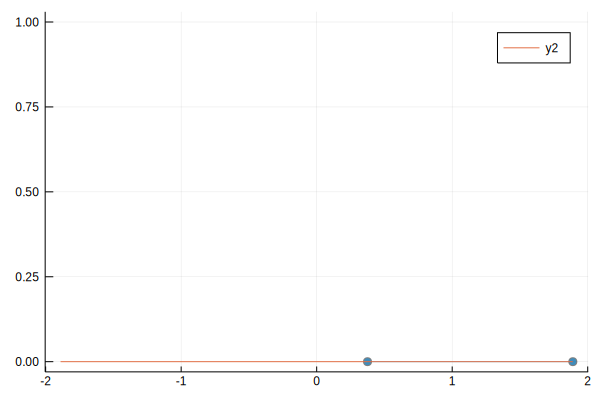

In [7]:
plot(x)
plot!(s)

In [12]:
function symmetric_interval_hull2(x::Interval)
    abs_inf = abs(min(x))
    abs_sup = abs(max(x))
    if abs_sup > abs_inf
        return Interval(-abs_sup, abs_sup)
    else
        return Interval(-abs_inf, abs_inf)
    end
end

symmetric_interval_hull2 (generic function with 1 method)

In [25]:
y = rand(Interval)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([-1.00815, 0.273332])

In [29]:
@which box_approximation_symmetric(y)

box_approximation_symmetric(x::Interval) in LazySets.Approximations at /home/mforets/.julia/dev/LazySets/src/Approximations/box_approximations.jl:70

In [24]:
@which symmetric_interval_hull(x)

box_approximation_symmetric(x::Interval) in LazySets.Approximations at /home/mforets/.julia/dev/LazySets/src/Approximations/box_approximations.jl:70

In [21]:
@btime symmetric_interval_hull2($x)

  0.016 ns (0 allocations: 0 bytes)


Interval{Float64,IntervalArithmetic.Interval{Float64}}([-1.8901, 1.8901])

In [11]:
@which min(x)

min(x::Interval{N,IN} where IN<:IntervalArithmetic.AbstractInterval{N}) where N<:Real in LazySets at /home/mforets/.julia/dev/LazySets/src/Sets/Interval.jl:289

In [13]:
symmetric_interval_hull2(x)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([-1.8901, 1.8901])

In [14]:
@btime symmetric_interval_hull2($x)

  0.015 ns (0 allocations: 0 bytes)


Interval{Float64,IntervalArithmetic.Interval{Float64}}([-1.8901, 1.8901])

In [15]:
minkowski_sum(x, x)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([2.2651395118499176], [1.515044368054411])

In [16]:
@which minkowski_sum(x, x)

minkowski_sum(H1::AbstractHyperrectangle{N}, H2::AbstractHyperrectangle{N}) where N<:Real in LazySets at /home/mforets/.julia/dev/LazySets/src/ConcreteOperations/minkowski_sum.jl:216

In [17]:
x + x

Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.750095, 3.78019])

In [8]:
H = rand(Hyperrectangle, dim=2)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.10772982367236603, 0.017475144401146867], [1.1798502663125028, 1.7899995333403507])

In [10]:
@btime symmetric_interval_hull($H)

  140.958 ns (6 allocations: 512 bytes)


Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0], [1.2875800899848688, 1.8074746777414976])

In [11]:
low(H)

2-element Array{Float64,1}:
 -1.2875800899848688
 -1.7725243889392037

In [12]:
high(H)

2-element Array{Float64,1}:
 1.0721204426401367
 1.8074746777414976

In [31]:
function sih2(H::Hyperrectangle)
    low_H = low(H)
    high_H = high(H)

    I1 = Interval(low_H[1], high_H[1])
    I2 = Interval(low_H[2], high_H[2])

    S1 = symmetric_interval_hull(I1)
    S2 = symmetric_interval_hull(I2)

    Hyperrectangle(low=[min(S1), min(S2)], high=[max(S1), max(S2)])
end

function sih3(H::Hyperrectangle{N}) where {N}
    # @assert dim(H) == 2
    @inbounds begin
        a1p = abs(H.center[1] + H.radius[1])
        a1m = abs(H.center[1] - H.radius[1])
        a2p = abs(H.center[2] + H.radius[2])
        a2m = abs(H.center[2] - H.radius[2])
    end  
    r1 = a1p > a1m ? a1p : a1m
    r2 = a2p > a2m ? a2p : a2m
    return Hyperrectangle(zeros(N, 2), [r1, r2])
end

sih3 (generic function with 1 method)

In [27]:
H.radius

2-element Array{Float64,1}:
 1.1798502663125028
 1.7899995333403507

In [23]:
sih2(H)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0], [1.2875800899848688, 1.8074746777414976])

In [24]:
symmetric_interval_hull(H)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0], [1.2875800899848688, 1.8074746777414976])

In [25]:
@btime sih2($H)

  160.756 ns (7 allocations: 608 bytes)


Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0], [1.2875800899848688, 1.8074746777414976])

In [34]:
@btime box_approximation_symmetric($H)

  140.574 ns (6 allocations: 512 bytes)


Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0], [1.2875800899848688, 1.8074746777414976])

In [32]:
sih3(H)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0], [1.2875800899848688, 1.8074746777414976])

In [33]:
@btime sih3($H)

  55.775 ns (3 allocations: 224 bytes)


Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0], [1.2875800899848688, 1.8074746777414976])

In [12]:
using LazySets, TreeView, SparseArrays

┌ Info: Precompiling TreeView [39424ebd-4cf3-5550-a685-96706a953f40]
└ @ Base loading.jl:1273


In [7]:
A = sprandn(1000, 1000, 0.01)
δ = 0.1;
X0 = Ball2(ones(1000), 0.1);
B = randn(1000, 2);
U = BallInf(zeros(2), 1.2);

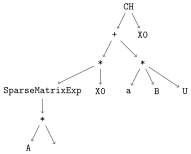

In [21]:
@tree CH(SparseMatrixExp(A * δ) * X0 + a * B * U, X0)

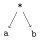

In [22]:
@tree a * b

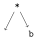

In [23]:
@tree α * b

In [24]:
using Plots

In [25]:
X = [rand(Hyperrectangle, dim=2) for _ in 1:100];

In [32]:
Xagrupado = [ConvexHullArray(X[i:i+9]) for i in 1:10:length(X)];

In [33]:
length(Xagrupado)

10

In [34]:
length(X)

100

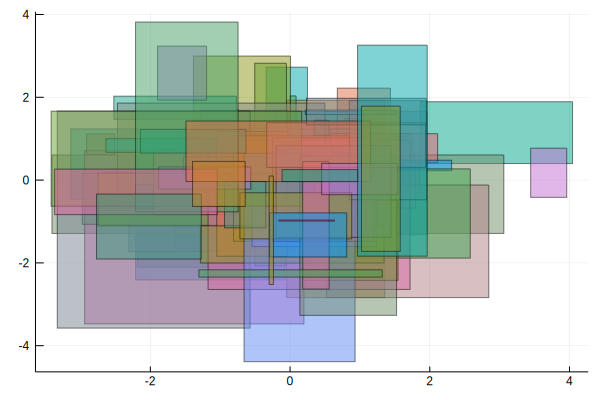

In [35]:
plot(X)

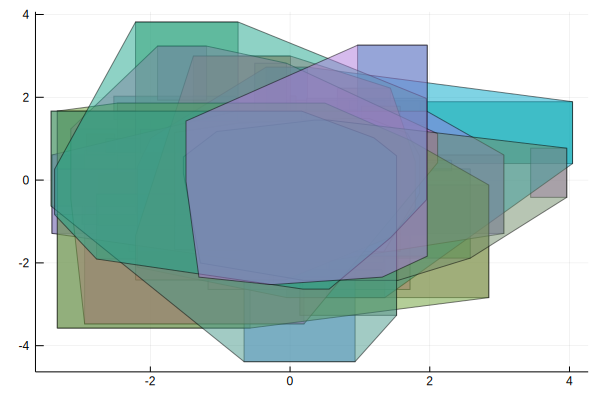

In [36]:
plot!(Xagrupado)